## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  

### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading
There are 5 graded problems, each worth 5 points, for a total of 25 points.

### Imports

In [260]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time
from sklearn.model_selection    import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble           import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.tree               import DecisionTreeClassifier
from sklearn.metrics            import mean_squared_error

from sklearn.metrics            import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing      import StandardScaler
from tqdm                       import tqdm
from typing                     import Any, Dict, List, Union, Tuple
from sklearn.base               import BaseEstimator
from collections                import Counter
# globals

random_state = 42


### Helper Functions

In [261]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [262]:
# print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
# print(classification_report(y_test, y_pred_log_reg, digits=4))

# # Plot Confusion Matrix
# fig, ax = plt.subplots(figsize=(5, 5))
# ConfusionMatrixDisplay.from_estimator(model_LR, X_test_scaled, y_test, cmap='Blues', ax=ax)
# ax.set_title("Confusion Matrix: LR Test Results")
# plt.show()

#### plot_confusion_matrix

In [263]:

# def plot_confusion_matrix(
#         y_test, 
#         y_pred, 
#         model_name, 
#         binary_outcome_labels, 
#         ax = None
#         ):
#     """Plots the confusion matrix with annotations and adds a classification report."""

#     if ax is None:
#         ax = plt.gca()

#     # Plot confusion matrix
#     disp = ConfusionMatrixDisplay.from_predictions(
#         y_test, 
#         y_pred,
#         display_labels  = binary_outcome_labels,
#         ax              = ax,
#         include_values  = False,
#         cmap            = 'viridis'  # 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
#     )
    
#     ax.set_title(f'{model_name} - Confusion Matrix')
#     # disp.im_.colorbar.remove()
#     disp.im_.colorbar.set_label('Number of Predictions')
#     # disp.ax_.set_xlabel('Predicted Label')

#     # Calculate confusion matrix
#     cm              = confusion_matrix(y_test, y_pred)
#     tn, fp, fn, tp  = cm.ravel()

#     # Calculate Specificity (True Negative Rate) and Sensitivity (True Positive Rate)
#     specificity = tn / (tn + fp)
#     sensitivity = tp / (tp + fn)

#     # Annotate confusion matrix with Specificity and Sensitivity
#     thresh              = cm.max() / 2.
#     stat_outcomes       = [['TN', 'FP'], ['FN', 'TP']]
#     stat_rate_outcomes  = [
#         [specificity, 1 - specificity],
#         [1 - sensitivity, sensitivity]
#     ]
#     for i, j in np.ndindex(cm.shape):
#         ax.text(j, i,
#                 f"{stat_outcomes[i][j]}\n{stat_rate_outcomes[i][j]:.1%}",
#                 horizontalalignment = "center",
#                 color = "white" if cm[i, j] < thresh else "black",
#                 fontsize = 9)

#     # Print classification report
#     print(f"Classification Report for {model_name}:\n")
#     print(classification_report(y_test, 
#                                 y_pred, 
#                                 target_names = binary_outcome_labels)
#                                 )

# # Example usage:
# # fig, ax = plt.subplots()
# # specificity, sensitivity = plot_confusion_matrix(y_test, y_pred, 'Model Name', ['Negative', 'Positive'], ax=ax)
# # plt.show()

In [264]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names, ax):
    """
    Plots the confusion matrix.
    
    Parameters:
        - y_true: True labels.
        - y_pred: Predicted labels.
        - model_name: Name of the model.
        - class_names: List of class names.
        - ax: Matplotlib axis object.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    plt.tight_layout()

#### plot_metrics

In [265]:
def plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, best_index, model_name):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": 9})

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean:
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy -----
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker='.', label=f"CV {metric}", color='midnightblue')
    ax1.plot(x_vals, train_accuracies, marker='.', label=f"Train {metric}", color='green')
    ax1.plot(x_vals, test_accuracies, linestyle='--', label=f"Test {metric}", color='orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s=100, label=f"Best CV {metric}", color='red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation -----
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {metric} Std", color='midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha=0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()

#### check_early_stopping

In [266]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### run_GridSearch_RandomizedSearch_CV

In [267]:
def run_GridSearch_RandomizedSearch_CV(
        ensemble_model, 
        parameter_grid, 
        randomized_search   = True,
        show_accuracy       = True,
        X_train             = X_train,
        y_train             = y_train,
        X_test              = X_test,
        y_test              = y_test,
        iterations          = 10,
        n_jobs              = -1,
        verbose             = True,
        n_repeats           = 10,
        cv_folds            = 5,
        random_state        = None
    ) -> pd.DataFrame:

    """
    Performs hyperparameter tuning for an ensemble model using either GridSearchCV or RandomizedSearchCV 
    from the scikit-learn library. Evaluates model's performance using repeated k-fold cross-validation and returns the best 
    parameters and their corresponding performance metrics.

        Parameters:
            - ensemble_model:                           ensemble model class to be tuned (e.g., RandomForestClassifier).
            - parameter_grid:                           Dictionary containing the hyperparameters to be tuned and their respective ranges/values.
            - randomized_search (bool, default=True):   If True, uses RandomizedSearchCV; otherwise, uses GridSearchCV.
            - show_accuracy (bool, default=True):       If True, calculate accuracy; otherwise, calculate another metric.
            - X_train:                                  Training feature set.
            - y_train:                                  Training target set.
            - X_test:                                   Test feature set.
            - y_test:                                   Test target set.
            - iterations (int, default=10):             Number of iterations for RandomizedSearchCV.
            - n_jobs (int, default=-1):                 Number of jobs to run in parallel. -1 means using all processors.
            - verbose (bool, default=True):             If True, prints detailed logs.
            - n_repeats (int, default=10):              Number of repeats for the cross-validation.
            - cv_folds (int, default=5):                Number of folds for cross-validation.
            - random_state (int, default=None):         Random seed for reproducibility.

        Returns:
            - best_params_df: DataFrame containing the best parameters and their corresponding performance metrics.
    """

    model                   = ensemble_model(random_state = random_state)
    model_name              = ensemble_model.__name__
    use_RandomizedSearchCV  = randomized_search

    # Use GridSearchCV or RandomizedSearchCV to find the best parameters
    if use_RandomizedSearchCV: 
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(
            estimator           = model,
            param_distributions = parameter_grid,
            n_iter              = iterations,
            scoring             = 'accuracy' if show_accuracy else 'neg_mean_squared_error',
            cv                  = cv_folds,
            n_jobs              = n_jobs,
            return_train_score  = True
        )
    else:
        print("Using GridSearchCV...")
        search = GridSearchCV(
            estimator           = model,
            param_grid          = parameter_grid,
            scoring             = 'accuracy' if show_accuracy else 'neg_mean_squared_error',
            cv                  = cv_folds,
            n_jobs              = n_jobs,
            return_train_score  = True
        )

    start = time.time()
    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results_df = pd.DataFrame(search.cv_results_)

    # Print the results as a table
    top_n = 10
    print(f"\nSearch Results (Top {top_n}):\n")
    print(results_df.head(top_n).to_string(index=False))

    # Best parameters and test performance
    print(f"\nBest Parameters: {search.best_params_}")

    best_score = search.best_score_
    print(f"Best CV Score: {best_score:,.4f}")

    # Evaluate on the test set
    y_pred          = search.best_estimator_.predict(X_test)
    test_score      = accuracy_score(y_test, y_pred) if show_accuracy else mean_squared_error(y_test, y_pred)
    print(f"Test Score: {test_score:,.4f}")

    # Record end time and execution time
    end             = time.time()
    execution_time  = format_hms(end - start)
    print(f"Execution Time: {execution_time} seconds")
    
    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    # Print the classification report and confusion matrix if it's a classification task
    if show_accuracy:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Compute training and testing accuracy
        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
        test_preds      = search.best_estimator_.predict(X_test)
        test_accuracy   = round(accuracy_score(y_test, test_preds), 4)
        
        # Plot confusion matrix
        fig, ax = plt.subplots()
        plot_confusion_matrix(y_test, 
                              test_preds, 
                              model_name, 
                              list(dict_outcome.values()), 
                              ax = ax
                              )

    # Create a DataFrame with the best parameters and their corresponding performance metrics
    best_params_df                          = pd.DataFrame([search.best_params_])
    best_params_df['Best CV Score']         = best_score
    best_params_df['Test Score']            = test_score
    best_params_df['Execution Time (s)']    = execution_time
    best_params_df['Timestamp']             = timestamp

    return best_params_df

In [268]:
# def run_GridSearch_RandomizedSearch_CV(
#         ensemble_model, 
#         parameter_grid, 
#         randomized_search   = True,
#         show_accuracy       = True,
#         X_train             = X_train,
#         y_train             = y_train,
#         X_test              = X_test,
#         y_test              = y_test,
#         iterations          = 10,
#         n_jobs              = -1,
#         verbose             = True,
#         n_repeats           = 10,
#         cv_folds            = 5,
#         random_state        = None
#     ) -> pd.DataFrame:

#     """
#     Performs hyperparameter tuning for an ensemble model using either GridSearchCV or RandomizedSearchCV 
#     from the scikit-learn library. Evaluates model's performance using repeated k-fold cross-validation and returns the best 
#     parameters and their corresponding performance metrics.

#         Parameters:
#             - ensemble_model:                           ensemble model class to be tuned (e.g., RandomForestClassifier).
#             - parameter_grid:                           Dictionary containing the hyperparameters to be tuned and their respective ranges/values.
#             - randomized_search (bool, default=True):   If True, uses RandomizedSearchCV; otherwise, uses GridSearchCV.
#             - show_accuracy (bool, default=True):       If True, calculate accuracy; otherwise, calculate another metric.
#             - X_train:                                  Training feature set.
#             - y_train:                                  Training target set.
#             - X_test:                                   Test feature set.
#             - y_test:                                   Test target set.
#             - iterations (int, default=10):             Number of iterations for RandomizedSearchCV.
#             - n_jobs (int, default=-1):                 Number of jobs to run in parallel. -1 means using all processors.
#             - verbose (bool, default=True):             If True, prints detailed logs.
#             - n_repeats (int, default=10):              Number of repeats for the cross-validation.
#             - cv_folds (int, default=5):                Number of folds for cross-validation.
#             - random_state (int, default=None):         Random seed for reproducibility.

#         Returns:
#             - best_params_df: DataFrame containing the best parameters and their corresponding performance metrics.
#     """

#     model                   = ensemble_model(random_state = random_state)
#     model_name              = ensemble_model.__name__
#     use_RandomizedSearchCV  = randomized_search

#     # Use GridSearchCV or RandomizedSearchCV to find the best parameters
#     if use_RandomizedSearchCV: 
#         print("Using RandomizedSearchCV...")
#         search = RandomizedSearchCV(
#             estimator           = model,
#             param_distributions = parameter_grid,
#             n_iter              = iterations,
#             scoring             = 'accuracy' if show_accuracy else 'neg_mean_squared_error',
#             cv                  = cv_folds,
#             n_jobs              = n_jobs,
#             return_train_score  = True
#         )
#     else:
#         print("Using GridSearchCV...")
#         search = GridSearchCV(
#             estimator           = model,
#             param_grid          = parameter_grid,
#             scoring             = 'accuracy' if show_accuracy else 'neg_mean_squared_error',
#             cv                  = cv_folds,
#             n_jobs              = n_jobs,
#             return_train_score  = True
#         )

#     start = time.time()
#     search.fit(X_train, y_train)

#     # Extract results into a DataFrame
#     results_df = pd.DataFrame(search.cv_results_)

#     # Print the results as a table
#     top_n = 10
#     print(f"\nSearch Results (Top {top_n}):\n")
#     print(results_df.head(top_n).to_string(index=False))

#     # Best parameters and test performance
#     print(f"\nBest Parameters: {search.best_params_}")

#     best_score = search.best_score_
#     print(f"Best CV Score: {best_score:,.4f}")

#     # Evaluate on the test set
#     y_pred          = search.best_estimator_.predict(X_test)
#     test_score      = accuracy_score(y_test, y_pred) if show_accuracy else mean_squared_error(y_test, y_pred)
#     print(f"Test Score: {test_score:,.4f}")

#     # Record end time and execution time
#     end             = time.time()
#     execution_time  = format_hms(end - start)
#     print(f"Execution Time: {execution_time} seconds")
    
#     timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
#     print(f'Completed at: {timestamp}')

#  # Print the classification report and confusion matrix if it's a classification task
#     if show_accuracy:
#         print("\nClassification Report:")
#         print(classification_report(y_test, y_pred, digits = 4))

#         # Compute training and testing accuracy
#         train_preds     = model.predict(X_train)
#         train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
#         test_preds      = model.predict(X_test)
#         test_accuracy   = round(accuracy_score(y_test, test_preds), 4)
        
#         # Plot confusion matrix
#         fig, ax = plt.subplots()
#         plot_confusion_matrix(y_test, 
#                               test_preds, 
#                               model_name, 
#                               list(dict_outcome.values()), 
#                               ax = ax
#                               )
#     # Print the classification report and confusion matrix if it's a classification task
#     # if show_accuracy:
#     #     print("\nClassification Report:")
#     #     print(classification_report(y_test, y_pred, digits=4))

#     #     fig, ax = plt.subplots(figsize=(5, 5))
#     #     ConfusionMatrixDisplay.from_estimator(search.best_estimator_, 
#     #                                           X_test, 
#     #                                           y_test, 
#     #                                           cmap  = 'viridis', 
#     #                                           ax    = ax
#     #                                     )
#     #     ax.set_title(f"{model_name} Confusion Matrix")
#     #     plt.tight_layout()
#     #     plt.show()

#     # Create a DataFrame with the best parameters and their corresponding performance metrics
#     best_params_df                          = pd.DataFrame([search.best_params_])
#     best_params_df['Best CV Score']         = best_score
#     best_params_df['Test Score']            = test_score
#     best_params_df['Execution Time (s)']    = execution_time
#     best_params_df['Timestamp']             = timestamp

#     return best_params_df

## Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

In [269]:
# Your code here

import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/arunram/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


In [270]:
# Load the dataset
df = pd.read_csv(os.path.join(path, 'diabetes.csv'))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [272]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


<Figure size 1600x1200 with 0 Axes>

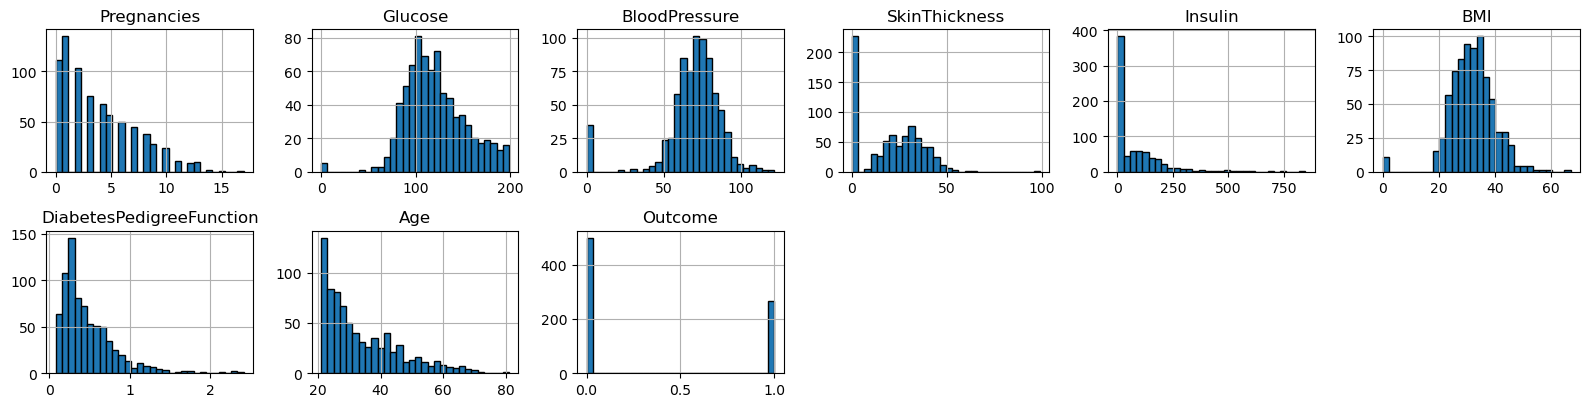

In [273]:
plt.figure(figsize = (16, 12)) 
df.hist(bins = 30, figsize = (16, 12), layout = (6, 6), edgecolor = 'black')

plt.tight_layout()  # Prevent labels from overlapping
plt.show()

In [274]:
# Check if the target is balanced
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [275]:
# Define the feature set X and the target set y
X = df.drop('Outcome', axis=1)
y = df['Outcome']

dict_outcome = {
    0: 'Non-diabetic', 
    1: 'Diabetic'
}

In [276]:
# Initialize the StandardScaler
scaler      = StandardScaler()

# Fit and transform the feature set
X_scaled    = scaler.fit_transform(X)

In [277]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size       = 0.2, 
                                                    random_state    = random_state
                                                    )

# Verify the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (614, 8)
X_test shape: (154, 8)
y_train shape: (614,)
y_test shape: (154,)


### Problem 1 Graded Answer

In [278]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape, X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


#### run_model

In [279]:

def run_model(
    model:          Union[BaseEstimator, type],  # The model or model class
    X_train:        np.ndarray,  # Training feature set
    y_train:        np.ndarray,  # Training target set
    X_test:         np.ndarray,  # Testing feature set
    y_test:         np.ndarray,  # Testing target set
    n_repeats:      int     = 10,  # Number of repeats for cross-validation
    cv_folds:       int     = 5,  # Number of k cross-validation folds
    n_jobs:         int     = -1,  # Number of jobs to run in parallel
    exp_factor:     float   = 1,  # Exponent factor for MSE values
    **model_params: Any  # Additional parameters for the model
) -> Tuple[float, float, float, float, int, int]:

    """
    Runs a machine learning model with cross-validation and computes performance metrics.

        Parameters:
            - model:            The machine learning model or model class to be used.
            - X_train:          Training feature set.
            - y_train:          Training target set.
            - X_test:           Testing feature set.
            - y_test:           Testing target set.
            - n_repeats:        Number of repeats for cross-validation (default is 10).
            - cv_folds:         Number of k cross-validation folds (default is 5).  
            - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
            - exp_factor:       Exponent factor to apply to the MSE values (default is 1).
            - **model_params:   Additional parameters to pass to the model if a class is provided.

        
        Returns (all raised to power of exp_factor):
            - mean_cv_accuracy:     Mean cross-validated accuracy
            - std_cv_accuracy:      Standard deviation of cross-validated MSE
            - train_accuracy:       Training set MSE
            - test_accuracy:        Testing set MSE
            - iterations:           Number of iterations
            - cv_folds:             Number of cross-validation folds
    """


    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    decimals = 4 # Number of decimal places to round to
    # Use RepeatedStratifiedKFold for classification to preserve class distribution    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, 
                                X_train, 
                                y_train, 
                                scoring = 'accuracy',
                                n_jobs  = n_jobs, 
                                cv      = RepeatedStratifiedKFold(n_splits      = cv_folds, 
                                                                  n_repeats     = n_repeats, 
                                                                  random_state  = random_state
                                                                  ), 
                               
                )
    
    mean_cv_accuracy = round(np.mean(cv_scores), decimals)
    std_cv_accuracy  = round(np.std(cv_scores), decimals)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    iterations  = n_repeats
    cv_folds    = cv_folds

    # Compute training and testing accuracy
    train_preds     = model.predict(X_train)
    train_accuracy  = round(accuracy_score(y_train, train_preds), decimals)
    test_preds      = model.predict(X_test)
    test_accuracy   = round(accuracy_score(y_test, test_preds), decimals)
    
    # Plot confusion matrix
    fig, ax         = plt.subplots()
    plot_confusion_matrix(y_test, 
                          test_preds, 
                          model.__class__.__name__, 
                          list(dict_outcome.values()), 
                          ax = ax
                          )

    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds


#### sweep_parameter

In [280]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10,
                    cv_folds         = 5
                    ) -> Dict[str, Any]:

    """
        Sweeps a specified parameter of a machine learning model and evaluates performance metrics.

            Parameters:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """ 

    decimals                = 4
    start                   = time.time()
    Parameters              = Parameters.copy()  # Avoid modifying the original dictionary
    
    print(f"Running {model.__name__} with {param} sweep...\n")

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count        = 0
    best_accuracy           = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc = f"Sweeping {param}"):
        Parameters[param]   = p
        P_temp              = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds = run_model(
            model           = model,
            X_train         = X_train, 
            y_train         = y_train,
            X_test          = X_test,  
            y_test          = y_test,
            n_repeats       = n_repeats,
            cv_folds        = cv_folds,
            n_jobs          = n_jobs,
            exp_factor      = 0.5 if show_rmse else 1,  
            **P_temp
        )
        print(f"{param} = {p}: CV_mean_accuracy = {mean_cv_accuracy:,.{decimals}f}, Train_accuracy = {train_accuracy:,.{decimals}f}, Test_accuracy = {test_accuracy:,.{decimals}f}")

        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        stop, best_accuracy, no_improve_count = check_early_stopping(mean_cv_accuracy, 
                                                                     best_accuracy, 
                                                                     no_improve_count, 
                                                                     delta, 
                                                                     n_iter_no_change
                                                                     )
        if stop:
            break
    
    # Identify best parameter
    max_cv_accuracy                 = max(cv_accuracies)
    max_index                       = cv_accuracies.index(max_cv_accuracy)
    best_param                      = parameter_list[max_index]
    Parameters['Test_Param']        = param
    Parameters[param]               = best_param
    Parameters['Model']             = model.__name__

    Parameters['accuracy_found']    = round(max_cv_accuracy, decimals)
    Parameters['n_repeats']         = n_repeats
    Parameters['cv_folds']          = cv_folds

    end                             = time.time()
    execution_time                  = end - start
    Parameters['execution_time']    = format_hms(execution_time)


    if verbose:
        plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, max_index, Parameters['Model'])
        
        # Print the timestamp of successful execution
        print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))

    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions

Baseline results for Logistic Regression:
 {'Model': 'LogisticRegression', 'Test_Param': 'Baseline', 'accuracy_found': 0.752, 'std_cv_accuracy': 0.029, 'train_accuracy': 0.761, 'test_accuracy': 0.695, 'cv_repeats': 5, 'n_repeats': 10, 'execution_time': '00:00:02', 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42}


{'Model': 'LogisticRegression',
 'Test_Param': 'Baseline',
 'accuracy_found': 0.752,
 'std_cv_accuracy': 0.029,
 'train_accuracy': 0.761,
 'test_accuracy': 0.695,
 'cv_repeats': 5,
 'n_repeats': 10,
 'execution_time': '00:00:02',
 'class_weight': 'balanced',
 'max_iter': 1000,
 'random_state': 42}

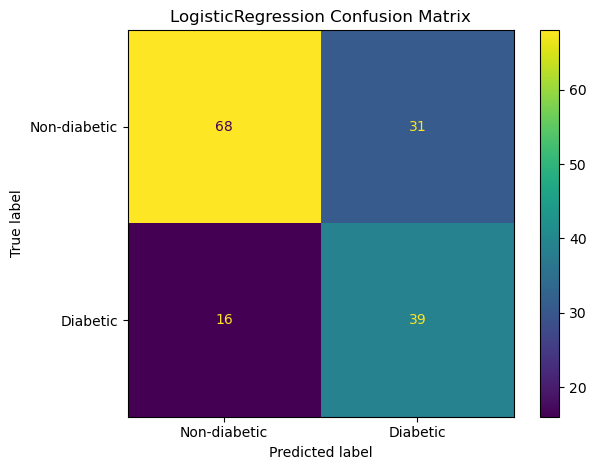

In [281]:
# Your code; add as many cells as you need

model_params = {
    'class_weight': 'balanced',
    'max_iter':     1000,
    'random_state': random_state
}       
model_2         = LogisticRegression

start           = time.time()

mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds  = run_model(
    model       = model_2,
    X_train     = X_train, 
    y_train     = y_train,
    X_test      = X_test,  
    y_test      = y_test,
    n_repeats   = 10,
    cv_folds    = 5,
    n_jobs      = -1,
    exp_factor  = 1,  # No exponent factor needed for accuracy
    **model_params
)

end             = time.time()
execution_time  = format_hms(end - start)

dict_LogReg_baseline = {
    'Model':            model_2.__name__,
    'Test_Param':       'Baseline',
    'accuracy_found':   round(mean_cv_accuracy, 3),
    'std_cv_accuracy':  round(std_cv_accuracy, 3),
    'train_accuracy':   round(train_accuracy, 3),
    'test_accuracy':    round(test_accuracy, 3),
    'cv_repeats':       cv_folds,
    'n_repeats':        iterations,
    'execution_time':   execution_time,
    **model_params
}

print("Baseline results for Logistic Regression:\n", dict_LogReg_baseline)
dict_LogReg_baseline


### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [282]:
# Insert the mean CV accuracy

a2a = dict_LogReg_baseline['accuracy_found']                             # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7520


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [283]:
# Insert the test accuracy

a2b = dict_LogReg_baseline['test_accuracy']                               # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.6950


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


Using RandomizedSearchCV...

Search Results (Top 10):

 mean_fit_time  std_fit_time  mean_score_time  std_score_time param_min_samples_split param_min_samples_leaf param_max_leaf_nodes param_max_depth param_criterion param_ccp_alpha                                                                                                                             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
      0.001545      0.000432         0.000431        0.000192                      10                      1                   11               6            gini            0.01     {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 11, 'max_depth': 6, 'criterion': 'gini', 'ccp_alpha': 0.01}           0.739837           0.796748          

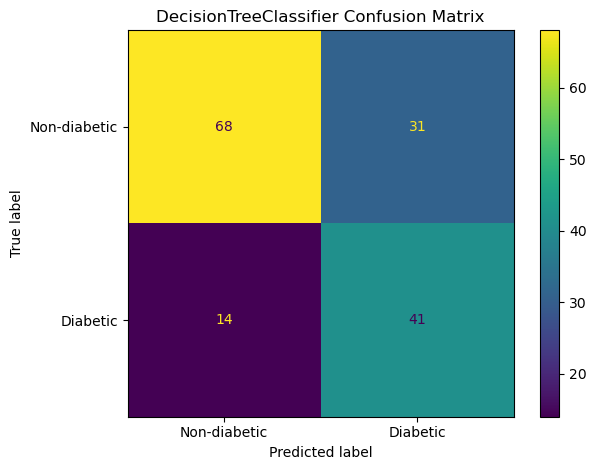

In [284]:
# Updated parameter grid with valid criteria for classifiers
param_grid_dt = {
    'criterion':            ['gini','entropy'],  # use valid classifier criteria
    'max_depth':            [4, 5, 6],
    'min_samples_split':    [9, 10, 11],
    'min_samples_leaf':     [1, 2],
    'max_leaf_nodes':       [9, 10, 11],
    'ccp_alpha':            [0.1, 0.05, 0.01, 0.005]
}


results_DecicionTreeClassifier_df = run_GridSearch_RandomizedSearch_CV(
    ensemble_model      = DecisionTreeClassifier,
    parameter_grid      = param_grid_dt,
    randomized_search   = True,
    show_accuracy       = True,
    X_train             = X_train,
    y_train             = y_train,
    X_test              = X_test,
    y_test              = y_test,
    iterations          = 10,
    n_jobs              = -1,
    verbose             = True,
    n_repeats           = 10,
    cv_folds            = 5,
    random_state        = random_state
)


Decision Tree Results:
Best Parameters: {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'min_samples_split': 9}

Cross-Validation Accuracy: 0.7704
Test Accuracy: 0.7078
              precision    recall  f1-score   support

           0     0.8293    0.6869    0.7514        99
           1     0.5694    0.7455    0.6457        55

    accuracy                         0.7078       154
   macro avg     0.6994    0.7162    0.6985       154
weighted avg     0.7365    0.7078    0.7136       154



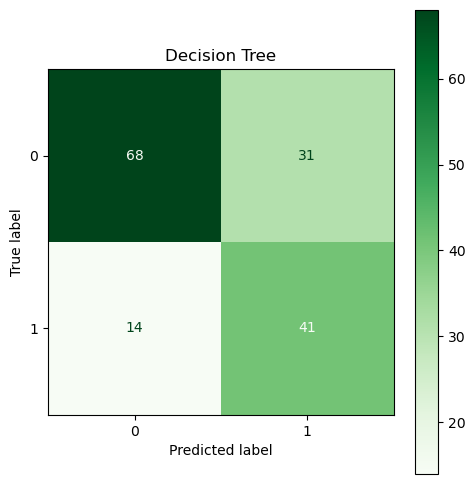

In [285]:
# Your code here

# Updated parameter grid with valid criteria for classifiers
param_grid_dt = {
    'criterion':            ['gini','entropy'],  # use valid classifier criteria
    'max_depth':            [4, 5, 6],
    'min_samples_split':    [9, 10, 11],
    'min_samples_leaf':     [1, 2],
    'max_leaf_nodes':       [9, 10, 11],
    'ccp_alpha':            [0.1, 0.05, 0.01, 0.005]
}

# Set n_jobs=-1 to use all available CPU cores
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state = random_state),
    param_grid_dt,
    cv      = 5,
    scoring = 'accuracy',
    n_jobs  = -1,        # leverage all available cores
)

grid_dt.fit(X_train, y_train)

best_dt         = grid_dt.best_estimator_ 
y_pred_dt       = best_dt.predict(X_test)
accuracy_CV     = grid_dt.best_score_
accuracy_test   = accuracy_score(y_test, y_pred_dt)

print("\nDecision Tree Results:")
print(f"Best Parameters: {grid_dt.best_params_}\n")
print(f"Cross-Validation Accuracy: {accuracy_CV:,.4f}")
print(f"Test Accuracy: {accuracy_test:,.4f}")

print(classification_report(y_test, y_pred_dt, digits = 4))

fig, ax = plt.subplots(figsize = (5, 5))
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap = 'Greens', ax = ax)
ax.set_title("Decision Tree")
plt.tight_layout()
plt.show()

### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [288]:
# Insert the mean CV accuracy

a3a = accuracy_CV                            # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.7704


### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [289]:
# Insert the test accuracy

a3b = accuracy_test                             # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.7078
